<a href="https://colab.research.google.com/github/AlvingEj/monitoreo_control_arvenses/blob/main/Proceso_de_Entrenamiento_y_Predicci%C3%B3n_para_Clasificaci%C3%B3n_de_Im%C3%A1genes_de_Tipos_y_Estados_de_Plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from google.colab import files

In [ ]:
def subir_y_descomprimir_zip():

    #Sube y descomprime un archivo zip.
    uploaded = files.upload()
    if uploaded:
        zip_filename = list(uploaded.keys())[0]
        try:
            with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
                zip_ref.extractall('dataset')
            print("Archivo zip descomprimido correctamente")
        except zipfile.BadZipFile:
            print("Error: El archivo subido no es un archivo zip válido.")
    else:
        print("Error: No se subió ningún archivo zip.")
    return os.listdir('dataset')

subir_y_descomprimir_zip()


In [ ]:
def verificar_estructura_directorios():

    #Verifica y muestra la estructura de directorios.
    print("Contenido de la carpeta 'dataset':")
    print(os.listdir('dataset'))

    if os.path.exists('dataset/dataset'):
        print("Contenido de la carpeta 'dataset/dataset':")
        print(os.listdir('dataset/dataset'))

        if os.path.exists('dataset/dataset/Manzana'):
            print("Contenido de la carpeta 'dataset/dataset/Manzana':")
            print(os.listdir('dataset/dataset/Manzana'))
        if os.path.exists('dataset/dataset/Uva'):
            print("Contenido de la carpeta 'dataset/dataset/Uva':")
            print(os.listdir('dataset/dataset/Uva'))

verificar_estructura_directorios()

Contenido de la carpeta 'dataset':
['dataset']
Contenido de la carpeta 'dataset/dataset':
['Manzana', 'Uva']
Contenido de la carpeta 'dataset/dataset/Manzana':
['Manzana_Sarna_Manzano', 'Manzana_Pondedumbre_Negra', 'Manzana_Sana', 'Manzana_Roya_Manzano']
Contenido de la carpeta 'dataset/dataset/Uva':
['Uva_Sarampion_Negro', 'Uva_Podredumbre_Negra', 'Uva_Tizon_Hoja', 'Uva_Sana']


In [ ]:
def crear_generadores_datos():
    """Crea generadores de datos para entrenamiento y validación."""
    datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Generador de datos para el tipo de planta
    train_generator_type = datagen.flow_from_directory(
        'dataset/dataset',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        subset='training'
    )
    validation_generator_type = datagen.flow_from_directory(
        'dataset/dataset',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        subset='validation'
    )
    print(f"Generador de datos para el tipo de planta creado: {train_generator_type.samples} muestras de entrenamiento y {validation_generator_type.samples} muestras de validación.")

    # Generador de datos para el estado de la planta para Manzana
    train_generator_status_A = datagen.flow_from_directory(
        'dataset/dataset/Manzana',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    validation_generator_status_A = datagen.flow_from_directory(
        'dataset/dataset/Manzana',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    print(f"Generador de datos para el estado de la planta de Manzana creado: {train_generator_status_A.samples} muestras de entrenamiento y {validation_generator_status_A.samples} muestras de validación.")

    # Generador de datos para el estado de la planta para Uva
    train_generator_status_B = datagen.flow_from_directory(
        'dataset/dataset/Uva',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='training'
    )
    validation_generator_status_B = datagen.flow_from_directory(
        'dataset/dataset/Uva',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
    )
    print(f"Generador de datos para el estado de la planta de Uva creado: {train_generator_status_B.samples} muestras de entrenamiento y {validation_generator_status_B.samples} muestras de validación.")

    return (train_generator_type, validation_generator_type,
            train_generator_status_A, validation_generator_status_A,
            train_generator_status_B, validation_generator_status_B)

(train_generator_type, validation_generator_type,
 train_generator_status_A, validation_generator_status_A,
 train_generator_status_B, validation_generator_status_B) = crear_generadores_datos()


Found 5702 images belonging to 2 classes.
Found 1425 images belonging to 2 classes.
Generador de datos para el tipo de planta creado: 5702 muestras de entrenamiento y 1425 muestras de validación.
Found 2498 images belonging to 4 classes.
Found 622 images belonging to 4 classes.
Generador de datos para el estado de la planta de Manzana creado: 2498 muestras de entrenamiento y 622 muestras de validación.
Found 3208 images belonging to 4 classes.
Found 799 images belonging to 4 classes.
Generador de datos para el estado de la planta de Uva creado: 3208 muestras de entrenamiento y 799 muestras de validación.


In [ ]:
def crear_modelo_tipo_planta():

    #Crea y compila el modelo para la clasificación del tipo de planta.
    model_type = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_type.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       metrics=['accuracy'])

    model_type.summary()
    return model_type

model_type = crear_modelo_tipo_planta()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def crear_modelo_estado_planta(num_clases):

    #Crea y compila el modelo para la clasificación del estado de la planta.
    model_status = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_clases, activation='softmax')
    ])

    model_status.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])
    model_status.summary()
    return model_status

model_status_A = crear_modelo_estado_planta(num_clases=4)
model_status_B = crear_modelo_estado_planta(num_clases=4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def entrenar_modelo(model, train_generator, validation_generator, epochs):

    #Entrena el modelo y devuelve el historial de entrenamiento.
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator
    )
    return history

history_type = entrenar_modelo(model_type, train_generator_type, validation_generator_type, epochs=25)
history_status_A = entrenar_modelo(model_status_A, train_generator_status_A, validation_generator_status_A, epochs=25)
history_status_B = entrenar_modelo(model_status_B, train_generator_status_B, validation_generator_status_B, epochs=25)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 23s 78ms/step - accuracy: 0.8031 - loss: 0.4449 - val_accuracy: 0.9649 - val_loss: 0.0881
Epoch 2/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - accuracy: 0.9701 - loss: 0.0895 - val_accuracy: 0.9368 - val_loss: 0.1905
Epoch 3/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9771 - loss: 0.0590 - val_accuracy: 0.9319 - val_loss: 0.1689
Epoch 4/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.9910 - loss: 0.0301 - val_accuracy: 0.8905 - val_loss: 0.3297
Epoch 5/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - accuracy: 0.9889 - loss: 0.0305 - val_accuracy: 0.9186 - val_loss: 0.2258
Epoch 6/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9895 - loss: 0.0337 - val_accuracy: 0.9579 - val_loss: 0.0928
Epoch 7/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - accuracy: 0.9921 - loss: 0.0218 - val_accuracy: 0.9670 - val_loss: 0.0970
Epoch 8/25
179/179 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.9940 - loss: 0.0152 - val_accurac

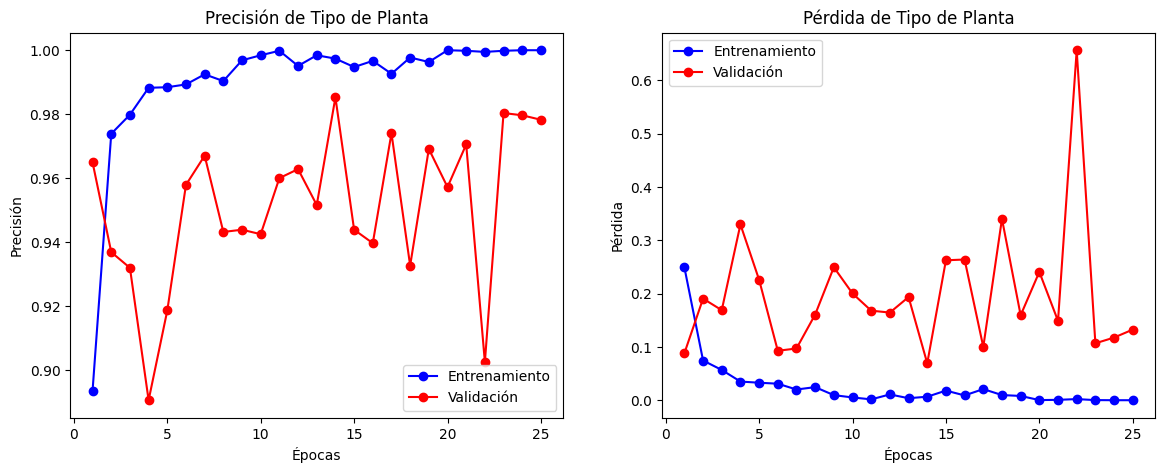

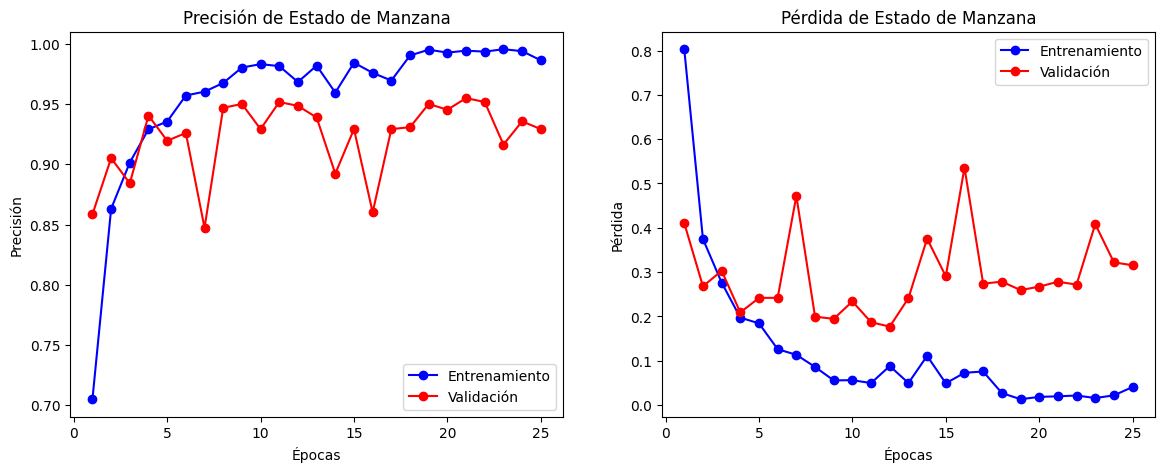

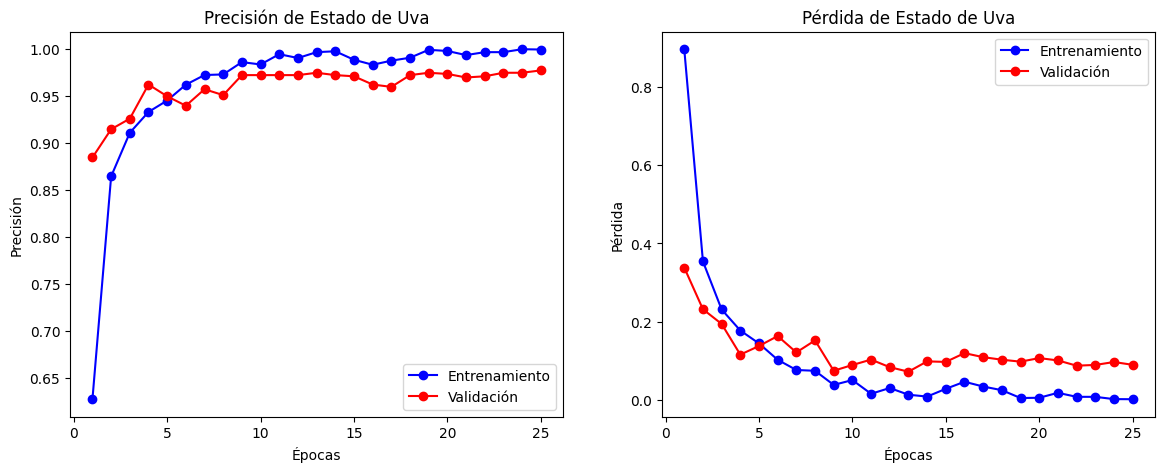

In [ ]:
def graficar_metricas(history, title):

    #Grafica las métricas de precisión y pérdida.
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Validación')
    plt.title(f'Precisión de {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Validación')
    plt.title(f'Pérdida de {title}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.legend()

    plt.show()

graficar_metricas(history_type, 'Tipo de Planta')
graficar_metricas(history_status_A, 'Estado de Manzana')
graficar_metricas(history_status_B, 'Estado de Uva')

In [ ]:
def guardar_modelos():

    #Guarda los modelos entrenados en archivos.
    model_type.save('modelo_tipo_planta.keras')
    model_status_A.save('modelo_estado_manzana.keras')
    model_status_B.save('modelo_estado_uva.keras')
    '''
    # Descarga los archivos a tu computadora.
    files.download('/content/modelo_tipo_planta.keras')
    files.download('/content/modelo_estado_manzana.keras')
    files.download('/content/modelo_estado_uva.keras')
    '''
guardar_modelos()

In [ ]:
'''
def cargar_modelos():

    #Cargar modelos
    model_type = tf.keras.models.load_model('modelo_tipo_planta.keras')
    model_status_A = tf.keras.models.load_model('modelo_estado_manzana.keras')
    model_status_B = tf.keras.models.load_model('modelo_estado_uva.keras')

    return model_type, model_status_A, model_status_B

model_type, model_status_A, model_status_B = cargar_modelos()
'''

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
def predecir_imagenes(model_type, model_status_A, model_status_B):

    #Predice el tipo y el estado de la planta de las imágenes subidas.
    estado_mapeo_uv = {
        0: 'Uva Podredumbre Negra',
        1: 'Uva Sana',
        2: 'Uva Sarampión Negro',
        3: 'Uva Tizón Hoja'
    }

    estado_mapeo_ma = {
        0: 'Manzana Podredumbre Negra',
        1: 'Manzana Roya Manzano',
        2: 'Manzana Sana',
        3: 'Manzana Sarna Manzano'
    }

    uploaded = files.upload()

    for filename in uploaded.keys():
        img_path = filename

        img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, axis=0) / 255.0

        plant_type = model_type.predict(img_array)
        plant_type_label = 1 if plant_type[0][0] >= 0.5 else 0

        if plant_type_label == 0:
            status = model_status_A.predict(img_array)
            estado_mapeo = estado_mapeo_ma
        else:
            status = model_status_B.predict(img_array)
            estado_mapeo = estado_mapeo_uv

        status_label_index = tf.argmax(status, axis=1).numpy()[0]
        status_label = estado_mapeo.get(status_label_index, 'Desconocido')

        plant_type_name = "Manzana" if plant_type_label == 0 else "Uva"
        print(f"{filename}: Tipo de planta - {plant_type_name}, Estado de la planta - {status_label}")

predecir_imagenes(model_type, model_status_A, model_status_B)

In [ ]:
'''
# Flujo principal
subir_y_descomprimir_zip()
verificar_estructura_directorios()

(train_generator_type, validation_generator_type,
 train_generator_status_A, validation_generator_status_A,
 train_generator_status_B, validation_generator_status_B) = crear_generadores_datos()

model_type = crear_modelo_tipo_planta()
history_type = entrenar_modelo(model_type, train_generator_type, validation_generator_type, epochs=25)
graficar_metricas(history_type, 'Tipo de Planta')

model_status_A = crear_modelo_estado_planta(num_clases=4)
history_status_A = entrenar_modelo(model_status_A, train_generator_status_A, validation_generator_status_A, epochs=25)
graficar_metricas(history_status_A, 'Estado de Manzana')

model_status_B = crear_modelo_estado_planta(num_clases=4)
history_status_B = entrenar_modelo(model_status_B, train_generator_status_B, validation_generator_status_B, epochs=25)
graficar_metricas(history_status_B, 'Estado de Uva')

predecir_imagenes(model_type, model_status_A, model_status_B)
'''